In [1]:
# ── Setup ──────────────────────────────────────────────────────────────
import sys, json, warnings
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML, Markdown

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_colwidth", 80)

# Resolve project root (works from analysis/ or project root)
ROOT = Path(".").resolve()
if ROOT.name == "analysis":
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# Theme
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
BLUE, GREEN, RED, GRAY = "#3274A1", "#3A923A", "#C03D3E", "#999999"

# ── Load data ──────────────────────────────────────────────────────────
from shared.data_loader import load_facility_patients, standardize_columns, create_record_id
from shared.ground_truth import (
    load_ground_truth,
    generate_true_pairs_from_ground_truth,
    add_record_ids_to_ground_truth,
)
from shared.evaluation import calculate_confusion_matrix, calculate_metrics

features     = pd.read_parquet(ROOT / "output/resolved/features.parquet")
auto_matches = pd.read_parquet(ROOT / "output/resolved/auto_matches.parquet")
gray_zone    = pd.read_parquet(ROOT / "output/resolved/gray_zone_pairs.parquet")
predictions  = pd.read_parquet(ROOT / "output/inferred/predictions.parquet")
all_matches  = pd.read_parquet(ROOT / "output/golden_records/all_matches.parquet")
golden_recs  = pd.read_parquet(ROOT / "output/golden_records/golden_records.parquet")
ground_truth = load_ground_truth(str(ROOT / "output/augmented"))

with open(ROOT / "output/resolved/resolve_metrics.json") as f:
    resolve_m = json.load(f)
with open(ROOT / "output/golden_records/evaluation_metrics.json") as f:
    eval_m = json.load(f)

# Build ground-truth pair set
clean_patients = load_facility_patients(str(ROOT / "output/segmented"))
clean_patients = standardize_columns(clean_patients)
clean_patients = create_record_id(clean_patients)
gt_with_ids = add_record_ids_to_ground_truth(ground_truth, clean_patients)
true_pairs = generate_true_pairs_from_ground_truth(gt_with_ids)

# ── Load pre-computed baseline comparison ──────────────────────────────
with open(ROOT / "output/baselines/baseline_comparison.json") as f:
    baselines = json.load(f)

demographic_only = baselines["scenarios"]["splink_best_f1"]
clinfuse         = baselines["scenarios"]["clinfuse"]

print(
    f"Data loaded: {resolve_m['num_records']:,} records, "
    f"{resolve_m['num_facilities']} facilities, {len(true_pairs):,} true pairs"
)

Data loaded: 6,264 records, 5 facilities, 5,708 true pairs


# ClinFuse: Three-Tier Entity Resolution for Medical Records

**Probabilistic linkage + clinical-context LLM for patient matching across fragmented health systems**

---

## Executive Summary

When patients visit multiple hospitals, duplicate records emerge — especially when demographics are entered inconsistently. Traditional probabilistic linkage works well for clean data but breaks down under heavy noise: typos, missing fields, maiden names, and address changes.

**ClinFuse** adds a clinical-context layer: a fine-tuned MedGemma 4B model that reads structured medical summaries (conditions, medications, vitals) to resolve the ambiguous pairs that demographics alone cannot confidently decide.

### Three-Tier Architecture

1. **Probabilistic demographic linkage** — Fellegi-Sunter EM on 7 demographic fields. High-confidence pairs are auto-matched; low-confidence pairs are auto-rejected.
2. **MedGemma gray zone classifier** — Fine-tuned MedGemma 4B classifies ambiguous pairs using structured clinical summaries.
3. **Logit-space fusion** — Combines demographic match probability + MedGemma prediction logit in log-odds space.

<p align="center">
  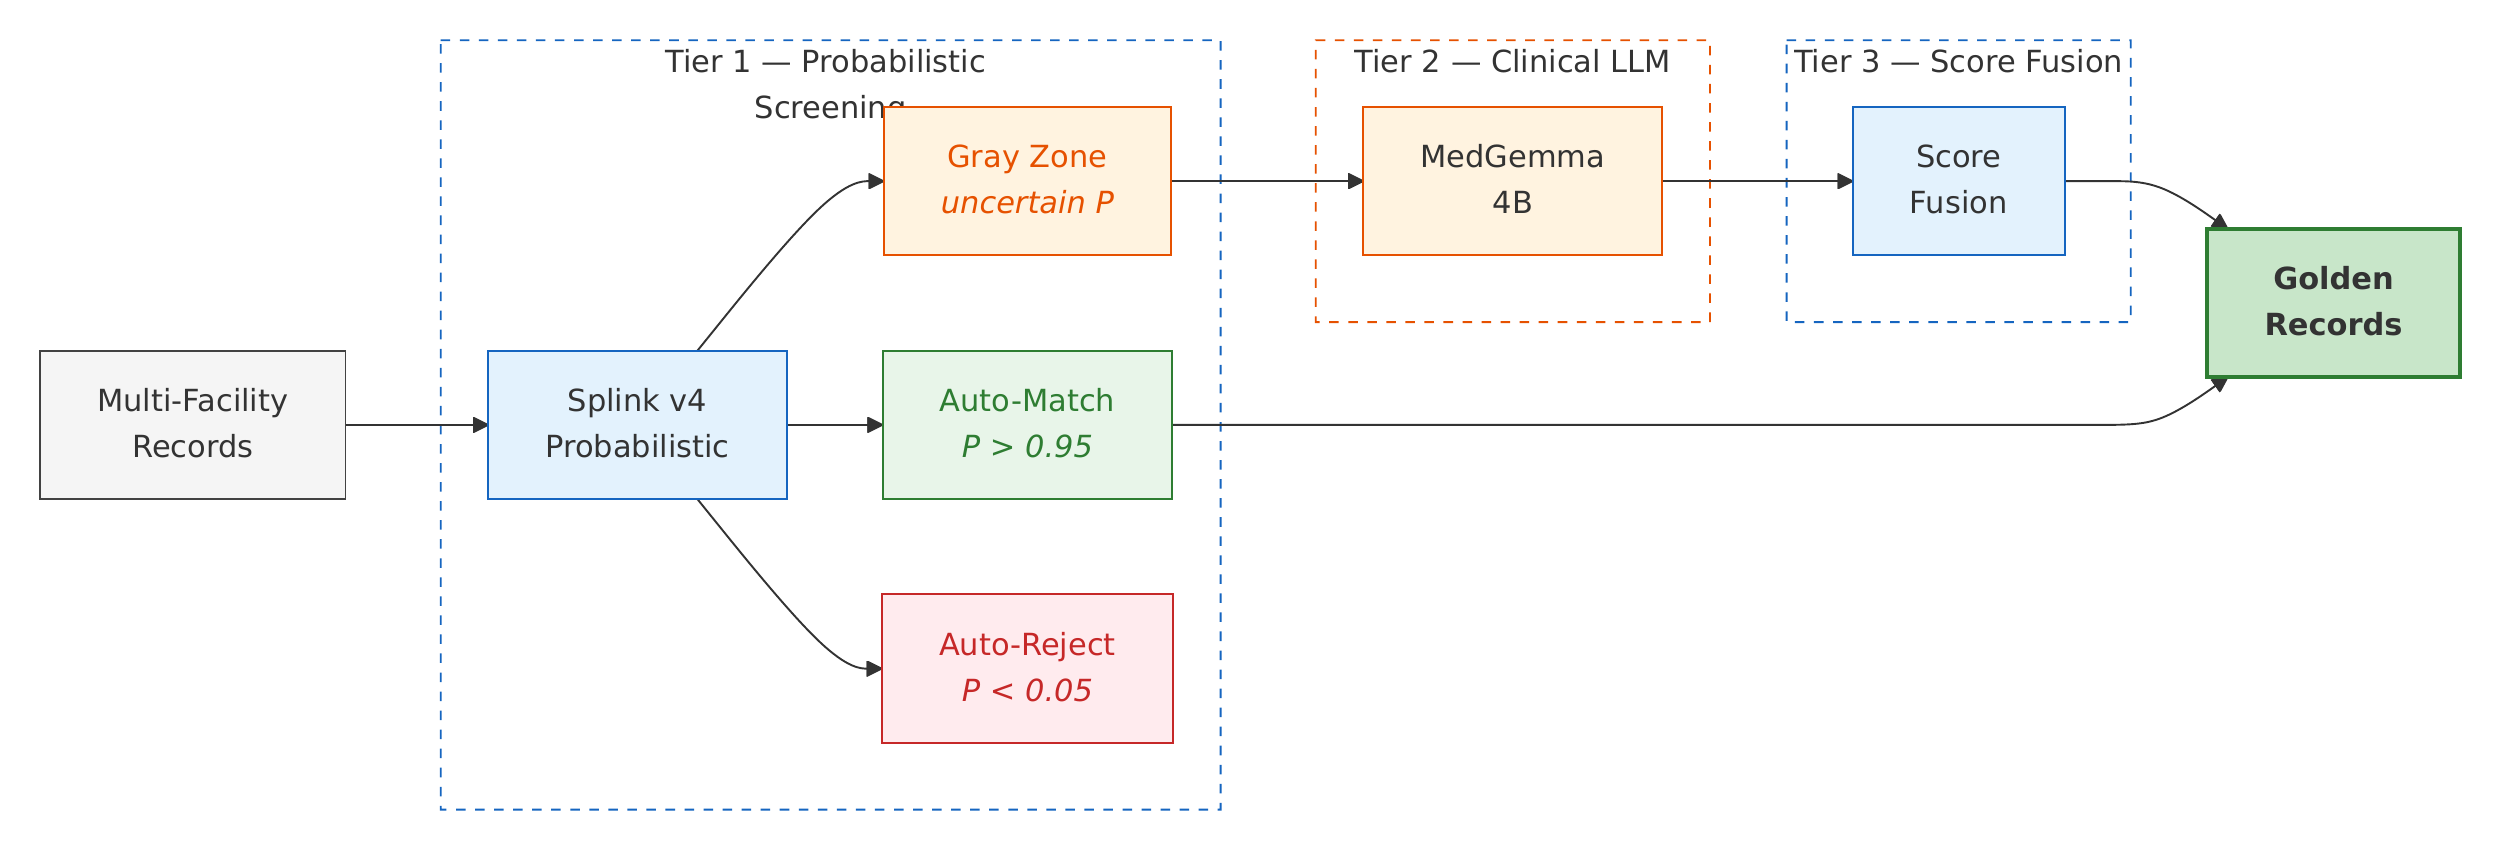
</p>

### Patient-Level Impact

A single recovered link can transitively unify an entire cluster of fragmented records. Pair-level F1 understates the real-world impact — what matters is whether *patients* are correctly resolved.

| | Demographics Only | + MedGemma | Reduction |
|---|---|---|---|
| **Split patients** | 421 | **115** | **73%** |
| **Fragmented patients** | 14.4% | **3.9%** | **73%** |
| **Unresolved patients** | 47.7% | **26.0%** | **46%** |
| **Missed matches** | 25.6% | **9.0%** | **65%** |

Each split patient is a real person whose records stay fragmented — duplicated tests, missed drug interactions, and gaps in care history.

---

## 1. Overall Results — Error Rate Reduction

Pair-level metrics (precision, recall, F1) count individual record pairs. But in entity resolution, a single recovered link can transitively merge an entire cluster. **Failure rates** capture the real-world impact more clearly: how many patients remain fragmented, unresolved, or have missed matches?

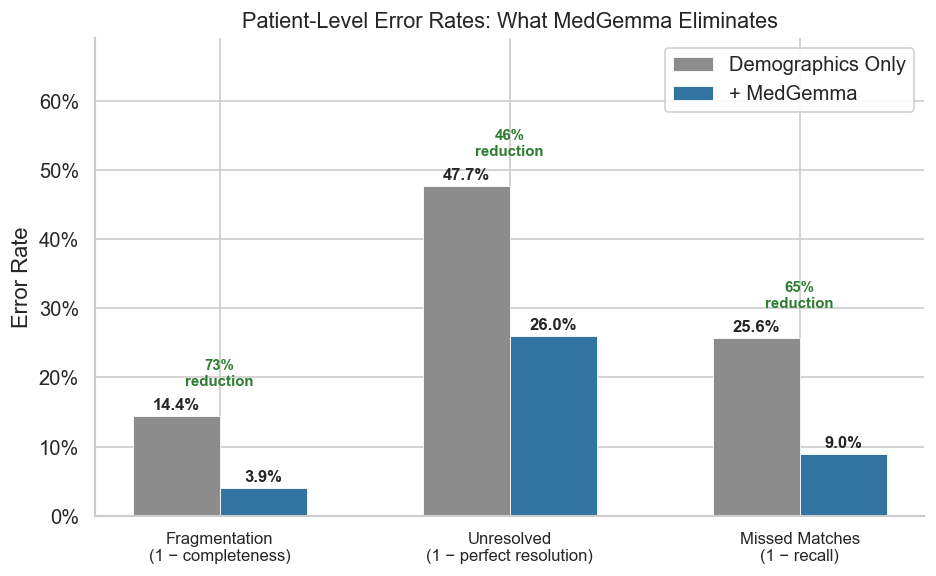

In [2]:
# ── Error-rate bar chart: Demographics Only vs + MedGemma ─────────────
scenarios = {
    "Demographics Only": demographic_only,
    "  + MedGemma": clinfuse,
}

# Failure rates = 1 - success rates
failure_keys = ["completeness", "perfect_resolution_rate"]
failure_labels = ["Fragmentation\n(1 − completeness)", "Unresolved\n(1 − perfect resolution)"]
# Add recall from pair_metrics
all_labels = failure_labels + ["Missed Matches\n(1 − recall)"]

bar_colors = ["#C44E52", "#DD8452", "#C03D3E"]
x = np.arange(len(all_labels))
width = 0.30

fig, ax = plt.subplots(figsize=(8, 5))
scenario_names = list(scenarios.keys())
scenario_colors = ["#8C8C8C", BLUE]

for si, (sname, sdata) in enumerate(scenarios.items()):
    vals = [
        1 - sdata["cluster_metrics"]["completeness"],
        1 - sdata["cluster_metrics"]["perfect_resolution_rate"],
        1 - sdata["pair_metrics"]["recall"],
    ]
    offset = (si - 0.5) * width
    bars = ax.bar(
        x + offset, vals, width, label=sname.strip(),
        color=scenario_colors[si], edgecolor="white", linewidth=0.5,
    )
    for bar, v in zip(bars, vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f"{v:.1%}", ha="center", va="bottom", fontsize=10, fontweight="bold",
        )

# Annotate % reduction between the two bars
demo_vals = [
    1 - demographic_only["cluster_metrics"]["completeness"],
    1 - demographic_only["cluster_metrics"]["perfect_resolution_rate"],
    1 - demographic_only["pair_metrics"]["recall"],
]
cf_vals = [
    1 - clinfuse["cluster_metrics"]["completeness"],
    1 - clinfuse["cluster_metrics"]["perfect_resolution_rate"],
    1 - clinfuse["pair_metrics"]["recall"],
]
for i, (dv, cv) in enumerate(zip(demo_vals, cf_vals)):
    reduction = (dv - cv) / dv
    mid_x = x[i]
    ax.annotate(
        f"{reduction:.0%}\nreduction",
        xy=(mid_x, max(dv, cv) + 0.04),
        ha="center", va="bottom", fontsize=9, fontweight="bold",
        color="#2E7D32",
    )

ax.set_xticks(x)
ax.set_xticklabels(all_labels, fontsize=10)
ax.set_ylim(0, max(demo_vals) * 1.45)
ax.set_ylabel("Error Rate")
ax.set_title("Patient-Level Error Rates: What MedGemma Eliminates", fontsize=13)
ax.legend(loc="upper right", framealpha=0.9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
sns.despine()
plt.tight_layout()
plt.show()

In [3]:
# ── Patient impact table (failure-rate framing) ──────────────────────
rows = []
for name, s in scenarios.items():
    cm = s["cluster_metrics"]
    pm = s["pair_metrics"]
    rows.append({
        "Scenario": name.strip(),
        "Split Patients": f"{cm['split_patients']:,}",
        "Fragmentation Rate": f"{1 - cm['completeness']:.1%}",
        "Unresolved Rate": f"{1 - cm['perfect_resolution_rate']:.1%}",
        "Missed Match Rate": f"{1 - pm['recall']:.1%}",
        "Pair F1": f"{pm['f1_score']:.3f}",
    })

impact_df = pd.DataFrame(rows).set_index("Scenario")

display(
    impact_df.style
    .apply(
        lambda s: ["font-weight: bold" if "MedGemma" in s.name else "" for _ in s],
        axis=1,
    )
    .set_caption(
        f"Patient-level error rates across {resolve_m['num_records']:,} records"
    )
    .set_table_styles(
        [{"selector": "caption", "props": "font-size: 1.1em; font-weight: bold; padding: 8px;"}]
    )
)

,Split Patients,Fragmentation Rate,Unresolved Rate,Missed Match Rate,Pair F1
Scenario,,,,,
Demographics Only,421,14.4%,47.7%,25.6%,0.764
+ MedGemma,115,3.9%,26.0%,9.0%,0.916


---

## 2. Case Study: One Patient, Five Facilities, Zero Automatic Matches

To understand *why* MedGemma matters, let's follow a single patient through the entire pipeline.

**Xiao Haag** is a 47-year-old woman from Weymouth, MA who has visited all 5 facilities in our system. After demographic error injection (simulating real-world data entry problems), her records became nearly unrecognizable:

- Her first name appears as **"Xuwo"**, **"Xksp"**, **"Xia8"**, and **"Xiao"**
- Her last name appears as **"Haag"**, **"Haa9"**, and **"Ullrich"** (maiden name)
- Her DOB is **missing from 4 of 5 facilities**
- Her SSN is missing, transposed, or has digit errors
- Her address is missing from 3 facilities and changed at 2 others

**Result:** Demographic linkage scored zero automatic matches. The highest pairwise probability was 0.87 — well below the 0.99 auto-match threshold. Without MedGemma, she would remain **5 separate patients** in the system.

In [4]:
# ── Case study: Xiao Haag ────────────────────────────────────────────
CASE_UUID = "4afd61a2-f3ac-66b7-2fd1-abccf2201456"
CASE_RIDS = [f"facility_{i:03d}_{CASE_UUID}" for i in range(1, 6)]

# Load augmented (error-injected) patients
aug_patients = load_facility_patients(str(ROOT / "output/augmented"))
aug_patients = standardize_columns(aug_patients)
aug_patients = create_record_id(aug_patients)

case_clean = clean_patients[clean_patients["record_id"].isin(CASE_RIDS)].copy()
case_aug = aug_patients[aug_patients["record_id"].isin(CASE_RIDS)].copy()

### 2a. Error Injection — What Each Facility Recorded

The table below shows the ground truth (green) and what each facility actually has on file. Red cells differ from the true value or are missing.

In [5]:
# ── Styled demographics table ─────────────────────────────────────────
DEMO_COLS = ["first_name", "last_name", "birthdate", "ssn", "address", "city", "zip"]
DEMO_LABELS = ["First Name", "Last Name", "DOB", "SSN", "Address", "City", "ZIP"]

# Ground truth row (from clean records — all identical pre-error)
gt_row = case_clean.iloc[0]

def fmt_val(val):
    if pd.isna(val) or str(val).lower() in ("nan", "nat", "none", "00nan"):
        return None
    if hasattr(val, "strftime"):
        return val.strftime("%Y-%m-%d")
    return str(val)

gt_vals = {label: fmt_val(gt_row[col]) for col, label in zip(DEMO_COLS, DEMO_LABELS)}

rows = [{"Facility": "Ground Truth", **gt_vals}]
for fac_num in range(1, 6):
    fac_id = f"facility_{fac_num:03d}"
    rec = case_aug[case_aug["facility_id"] == fac_id]
    if len(rec) == 0:
        continue
    rec = rec.iloc[0]
    row_data = {"Facility": f"Facility {fac_num}"}
    for col, label in zip(DEMO_COLS, DEMO_LABELS):
        v = fmt_val(rec[col])
        row_data[label] = v if v is not None else "\u2014"  # em dash for missing
    rows.append(row_data)

demo_df = pd.DataFrame(rows).set_index("Facility")

def style_demo_table(styler):
    def _apply(row):
        if row.name == "Ground Truth":
            return ["background-color: #d4edda; color: #1a1a1a; font-weight: bold"] * len(row)
        styles = []
        for col in row.index:
            cell = row[col]
            gt = gt_vals.get(col)
            if cell == "\u2014" or cell != gt:
                styles.append("background-color: #f8d7da; color: #1a1a1a")
            else:
                styles.append("background-color: #d4edda; color: #1a1a1a")
        return styles
    return styler.apply(_apply, axis=1)

display(
    style_demo_table(demo_df.style)
    .set_caption("Patient demographics: Ground truth vs. what each facility recorded")
    .set_table_styles(
        [{"selector": "caption", "props": "font-size: 1.1em; font-weight: bold; padding: 8px;"}]
    )
)

,First Name,Last Name,DOB,SSN,Address,City,ZIP
Facility,,,,,,,
Ground Truth,Xiao,Haag,1978-07-31,999533849,935 Schowalter Wynd,Weymouth,02191
Facility 1,Xuwo,Haag,—,995933849,—,Weymouth,—
Facility 2,Xksp,Haag,1978-07-01,—,—,—,2191.0
Facility 3,Xia8,Haa9,—,999533949,—,—,2191.0
Facility 4,Xiao,Ullrich,—,999533849,5887 WALNUT CIRCLE,Weymouth,—
Facility 5,Xiao,Haag,—,—,5799 CHERRY BOULEVARD,—,2191.0


**45 errors** were injected across these 5 records:

- **Facility 1:** First name mutated 3 times (Xiao -> Xuqo -> Xiqo -> Xuwo), SSN transposed, DOB/address/ZIP all missing
- **Facility 2:** First name multi-char typo (Xksp), SSN missing, city/address missing, DOB off-by-one then transposed
- **Facility 3:** First name typo with digit (Xia8), last name digit (Haa9), SSN digit error, DOB/city/address missing
- **Facility 4:** Maiden name used as last name (Ullrich), full address change, DOB/ZIP missing
- **Facility 5:** Full address change, SSN/DOB/city missing

No two facilities share the same combination of correct fields. This is the worst case for probabilistic matching.

### 2b. What Splink Sees — Pairwise Match Probabilities

Splink compares every pair of records using 7 demographic fields with a Fellegi-Sunter EM model. The heatmap shows the match probability for each of the 10 possible pairs.

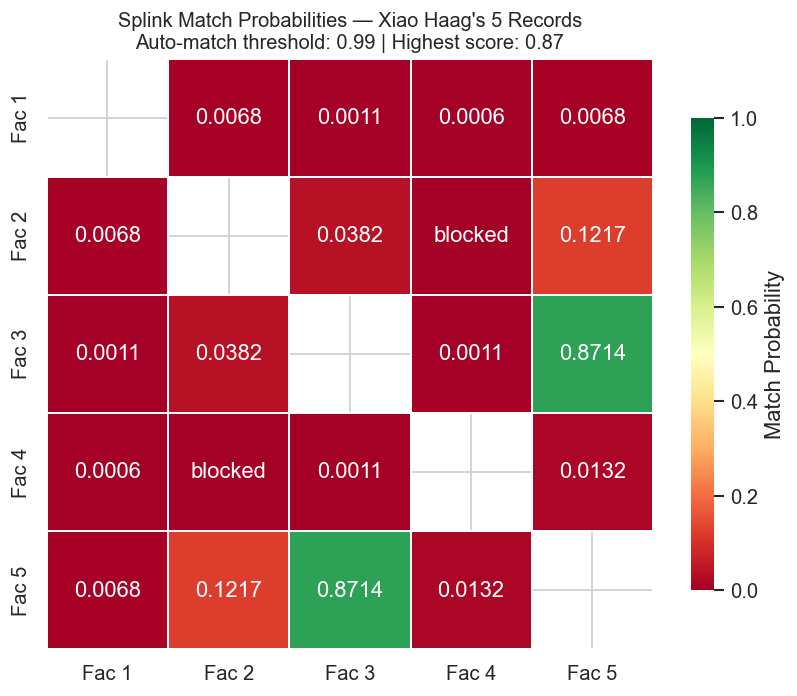

Every cell should be near 1.0 (same patient). The highest score is 0.87 — all pairs fall below the 0.99 auto-match threshold.
The Fac 2 ↔ Fac 4 pair was never generated by Splink's blocking rules (no shared blocking key).


In [6]:
# ── 5x5 Splink match probability heatmap ──────────────────────────────
case_features = features[
    features["record_id_1"].isin(CASE_RIDS)
    & features["record_id_2"].isin(CASE_RIDS)
]

fac_labels = [f"Fac {i}" for i in range(1, 6)]
fac_map = {f"facility_{i:03d}_{CASE_UUID}": i - 1 for i in range(1, 6)}

prob_matrix = np.full((5, 5), np.nan)
np.fill_diagonal(prob_matrix, 1.0)
for _, row in case_features.iterrows():
    i = fac_map[row["record_id_1"]]
    j = fac_map[row["record_id_2"]]
    prob_matrix[i, j] = row["match_probability"]
    prob_matrix[j, i] = row["match_probability"]

# Annotation matrix
annot = np.empty((5, 5), dtype=object)
for i in range(5):
    for j in range(5):
        if i == j:
            annot[i, j] = "\u2014"
        elif np.isnan(prob_matrix[i, j]):
            annot[i, j] = "blocked"
            prob_matrix[i, j] = 0.0  # for colormap
        else:
            annot[i, j] = f"{prob_matrix[i, j]:.4f}"

mask = np.eye(5, dtype=bool)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    prob_matrix, mask=mask, annot=annot, fmt="",
    xticklabels=fac_labels, yticklabels=fac_labels,
    cmap="RdYlGn", vmin=0, vmax=1, linewidths=1, linecolor="white",
    cbar_kws={"label": "Match Probability", "shrink": 0.8},
    ax=ax,
)
ax.set_title(
    "Splink Match Probabilities \u2014 Xiao Haag's 5 Records\n"
    "Auto-match threshold: 0.99 | Highest score: 0.87",
    fontsize=12,
)
plt.tight_layout()
plt.show()

print(
    "Every cell should be near 1.0 (same patient). The highest score is 0.87 \u2014 "
    "all pairs fall below the 0.99 auto-match threshold."
)
print(
    "The Fac 2 \u2194 Fac 4 pair was never generated by Splink's blocking rules "
    "(no shared blocking key)."
)

### 2c. What the LLM Sees — Clinical Summaries

All 9 existing pairs entered the gray zone. For each, ClinFuse builds structured clinical summaries from the medical records and asks MedGemma: *same patient or not?*

Below is the **hardest pair**: Facility 1 ("Xuwo Haag") vs. Facility 4 ("Xiao Ullrich") — Splink P = **0.0006**. The demographics say "different people." The clinical history tells a different story.

In [7]:
# ── Side-by-side clinical summary cards ───────────────────────────────
r1 = f"facility_001_{CASE_UUID}"
r4 = f"facility_004_{CASE_UUID}"

pair_row = gray_zone[
    ((gray_zone["record_id_1"] == r1) & (gray_zone["record_id_2"] == r4))
    | ((gray_zone["record_id_1"] == r4) & (gray_zone["record_id_2"] == r1))
].iloc[0]

full_text = pair_row["text"]

# Split prompt into Record A / Record B sections
parts = full_text.split("Record B:")
record_a_section = parts[0].split("Record A:")[1].strip()
record_b_section = parts[1].split("Are these the same patient?")[0].strip()

import html as html_mod

card_html = f"""
<div style="display: flex; gap: 16px; margin: 16px 0;">
  <div style="flex: 1; border: 2px solid {BLUE}; border-radius: 8px; padding: 16px; background: #f8f9fa;">
    <h4 style="color: {BLUE}; margin-top: 0;">Record A \u2014 Facility 1<br>
    <small>"Xuwo Haag" | Splink P = 0.0006</small></h4>
    <pre style="white-space: pre-wrap; font-size: 11px; line-height: 1.5; max-height: 400px; overflow-y: auto;">{html_mod.escape(record_a_section)}</pre>
  </div>
  <div style="flex: 1; border: 2px solid {GREEN}; border-radius: 8px; padding: 16px; background: #f8f9fa;">
    <h4 style="color: {GREEN}; margin-top: 0;">Record B \u2014 Facility 4<br>
    <small>"Xiao Ullrich" | Different name, different address</small></h4>
    <pre style="white-space: pre-wrap; font-size: 11px; line-height: 1.5; max-height: 400px; overflow-y: auto;">{html_mod.escape(record_b_section)}</pre>
  </div>
</div>
"""
display(HTML(card_html))

print("Despite completely different names and addresses, both records share:")
print("  - Same height (159.6 cm), weight (70.7 kg), BMI (27.8)")
print("  - Same medications: Hydrochlorothiazide 25 MG, lisinopril 10 MG")
print("  - Overlapping procedures: rehabilitation therapy, depression screening")
print("  - Consistent vital signs and lab values")
print(f"\nMedGemma verdict: MATCH (confidence: 99.99%)")

Despite completely different names and addresses, both records share:
  - Same height (159.6 cm), weight (70.7 kg), BMI (27.8)
  - Same medications: Hydrochlorothiazide 25 MG, lisinopril 10 MG
  - Overlapping procedures: rehabilitation therapy, depression screening
  - Consistent vital signs and lab values

MedGemma verdict: MATCH (confidence: 99.99%)


In [8]:
# ── Instruction prompt template ───────────────────────────────────────
from shared.summarize import INSTRUCTION

display(HTML(f"""
<div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; background: #fffef0; margin: 8px 0;">
  <h4 style="margin-top: 0;">Prompt Template</h4>
  <pre style="white-space: pre-wrap; font-size: 12px;">{html_mod.escape(INSTRUCTION)}</pre>
</div>
"""))

### 2d. Resolution — LLM Decisions and Network Graph

The LLM evaluated all 9 gray zone pairs. One pair (Facility 2 <-> Facility 4) was never generated by Splink's blocking rules — their records share no blocking key.

In [9]:
# ── LLM decision table ────────────────────────────────────────────────
case_preds = predictions[
    predictions["record_id_1"].isin(CASE_RIDS)
    & predictions["record_id_2"].isin(CASE_RIDS)
].copy()


def fac_num(rid):
    return int(rid.split("_")[1])


case_preds["Pair"] = case_preds.apply(
    lambda r: f"Fac {fac_num(r['record_id_1'])} \u2194 Fac {fac_num(r['record_id_2'])}",
    axis=1,
)
case_preds["Splink P"] = case_preds["total_score"].map("{:.4f}".format)
case_preds["LLM Decision"] = case_preds["prediction"].map({1: "MATCH", 0: "NO MATCH"})
case_preds["LLM Confidence"] = case_preds["confidence"].map("{:.2%}".format)

decision_df = case_preds[
    ["Pair", "Splink P", "LLM Decision", "LLM Confidence"]
].sort_values("Splink P")

display(
    decision_df.style.hide(axis="index")
    .apply(
        lambda row: [
            "", "",
            "background-color: #d4edda; color: #1a1a1a; font-weight: bold"
            if row["LLM Decision"] == "MATCH"
            else "background-color: #f8d7da; color: #1a1a1a",
            "",
        ],
        axis=1,
    )
    .set_caption("LLM decisions for Xiao Haag's 9 gray zone pairs")
    .set_table_styles(
        [{"selector": "caption", "props": "font-size: 1.1em; font-weight: bold; padding: 8px;"}]
    )
)

print("\n9 of 9 pairs correctly identified as matches.")
print(
    "Note: The Fac 2 \u2194 Fac 4 pair never reached the LLM \u2014 Splink's blocking "
    "rules missed it entirely (no shared blocking key)."
)

Pair,Splink P,LLM Decision,LLM Confidence
Fac 1 ↔ Fac 4,0.0006,MATCH,99.99%
Fac 3 ↔ Fac 4,0.0011,MATCH,99.99%
Fac 1 ↔ Fac 3,0.0011,MATCH,99.98%
Fac 1 ↔ Fac 2,0.0068,MATCH,99.99%
Fac 1 ↔ Fac 5,0.0068,MATCH,99.99%
Fac 4 ↔ Fac 5,0.0132,MATCH,99.99%
Fac 2 ↔ Fac 3,0.0382,MATCH,100.00%
Fac 2 ↔ Fac 5,0.1217,MATCH,99.98%
Fac 3 ↔ Fac 5,0.8714,MATCH,99.99%



9 of 9 pairs correctly identified as matches.
Note: The Fac 2 ↔ Fac 4 pair never reached the LLM — Splink's blocking rules missed it entirely (no shared blocking key).


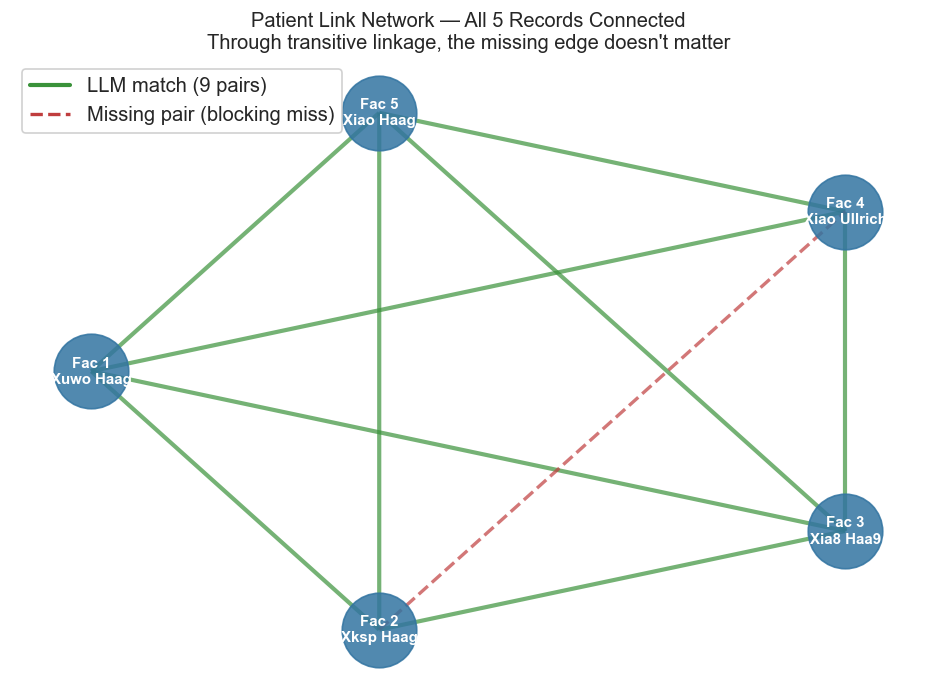

In [10]:
# ── Network graph: 5 facility nodes, 9 green edges, 1 red dashed ─────
corrupted_names = {
    1: "Xuwo Haag",
    2: "Xksp Haag",
    3: "Xia8 Haa9",
    4: "Xiao Ullrich",
    5: "Xiao Haag",
}

G = nx.Graph()
for i in range(1, 6):
    G.add_node(i, label=f"Fac {i}\n{corrupted_names[i]}")

# LLM-matched edges
matched_edges = []
for _, row in case_preds.iterrows():
    i = fac_num(row["record_id_1"])
    j = fac_num(row["record_id_2"])
    matched_edges.append((i, j))
    G.add_edge(i, j)

# Missing edge (blocking miss)
missing_edge = (2, 4)
G.add_edge(*missing_edge)

fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.shell_layout(G)
labels = nx.get_node_attributes(G, "label")

# Matched edges (green, solid)
nx.draw_networkx_edges(
    G, pos, edgelist=matched_edges, edge_color=GREEN,
    width=2.5, alpha=0.7, ax=ax,
)
# Missing edge (red, dashed)
nx.draw_networkx_edges(
    G, pos, edgelist=[missing_edge], edge_color=RED,
    width=2, style="dashed", alpha=0.7, ax=ax,
)
# Nodes
nx.draw_networkx_nodes(G, pos, node_color=BLUE, node_size=2000, alpha=0.85, ax=ax)
nx.draw_networkx_labels(
    G, pos, labels=labels, font_size=9, font_color="white", font_weight="bold", ax=ax,
)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=GREEN, linewidth=2.5, label="LLM match (9 pairs)"),
    Line2D(
        [0], [0], color=RED, linewidth=2, linestyle="dashed",
        label="Missing pair (blocking miss)",
    ),
]
ax.legend(handles=legend_elements, loc="upper left", framealpha=0.9)
ax.set_title(
    "Patient Link Network \u2014 All 5 Records Connected\n"
    "Through transitive linkage, the missing edge doesn't matter",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

**9 of 10 possible links recovered.** Even though the Fac 2 <-> Fac 4 pair was never compared (blocking miss), the remaining 9 edges form a **connected graph**. Through transitive linkage, all 5 records are unified into a single patient cluster.

### 2e. Golden Record vs. Ground Truth

Once the 5 records are linked, ClinFuse builds a **golden record** by majority voting across all linked records for each field.

In [11]:
# ── Golden record vs ground truth ─────────────────────────────────────
golden_row = None
for _, row in golden_recs.iterrows():
    src_ids = str(row["source_record_ids"]).split(",")
    if any(rid in CASE_RIDS for rid in src_ids):
        golden_row = row
        break

gt_clean = case_clean.iloc[0]  # all clean records are identical

compare_fields = [
    ("First Name", "first_name"),
    ("Last Name", "last_name"),
    ("Maiden Name", "maiden_name"),
    ("Date of Birth", "birthdate"),
    ("Gender", "gender"),
    ("SSN", "ssn"),
    ("Address", "address"),
    ("City", "city"),
    ("ZIP", "zip"),
]

rows = []
for label, col in compare_fields:
    gt_val = fmt_val(gt_clean[col]) or "\u2014"
    gr_val = fmt_val(golden_row[col]) if golden_row is not None else "\u2014"
    gr_val = gr_val or "\u2014"
    match = gt_val.upper().strip() == gr_val.upper().strip()
    rows.append({
        "Field": label,
        "Ground Truth": gt_val,
        "Golden Record": gr_val,
        "Match": "Yes" if match else "No",
    })

compare_df = pd.DataFrame(rows).set_index("Field")

display(
    compare_df.style
    .apply(
        lambda row: [f"background-color: {'#d4edda' if row['Match'] == 'Yes' else '#f8d7da'}; color: #1a1a1a"] * len(row),
        axis=1,
    )
    .set_caption("Golden record reconstruction from 5 linked records")
    .set_table_styles(
        [{"selector": "caption", "props": "font-size: 1.1em; font-weight: bold; padding: 8px;"}]
    )
)

n_match = sum(1 for r in rows if r["Match"] == "Yes")
print(f"\n{n_match} of {len(rows)} fields correctly recovered through majority voting.")
print()
print("The critical achievement is linkage: all 5 records were correctly unified")
print("into a single patient cluster despite zero auto-matches.")
print()
print("Some field values differ from ground truth because majority voting selects")
print("the most common value across error-injected records. With 45 errors across")
print("5 records, some corrupted values outnumber the correct ones.")

,Ground Truth,Golden Record,Match
Field,,,
First Name,Xiao,Xiao,Yes
Last Name,Haag,Haag,Yes
Maiden Name,Ullrich,Ullrich,Yes
Date of Birth,1978-07-31,1978-07-01,No
Gender,F,F,Yes
SSN,999533849,995933849,No
Address,935 Schowalter Wynd,5887 WALNUT CIRCLE,No
City,Weymouth,Weymouth,Yes
ZIP,02191,2191.0,No



5 of 9 fields correctly recovered through majority voting.

The critical achievement is linkage: all 5 records were correctly unified
into a single patient cluster despite zero auto-matches.

Some field values differ from ground truth because majority voting selects
the most common value across error-injected records. With 45 errors across
5 records, some corrupted values outnumber the correct ones.


---

## 3. Computational Feasibility

The three-tier design is efficient by construction: Splink screens all candidate pairs on CPU in seconds, and the LLM only processes the uncertain remainder. This section quantifies the cost.

Stage Breakdown (this dataset: 2,500 patients, 8–12 errors/record)
════════════════════════════════════════════════════════════════════════
Stage                               Pairs         Time     Cost
────────────────────────────────────────────────────────────────────────
Splink screening (CPU)            154,241     ~seconds        —
  → auto-match                      2,932
  → auto-reject                         0
  → gray zone → LLM               151,309
MedGemma classifier (H100)        151,309         2.1h       $6
────────────────────────────────────────────────────────────────────────
Total                             154,241         2.1h       $6

Throughput: ~20 comparisons/sec  │  Gray zone: 98.1% of candidates  │  GPU: H100 (4-bit quantized, <8 GB VRAM)


Real-World Projection
════════════════════════════════════════════════════════════════════════
This dataset deliberately uses extreme error rates (8–12 per record)
to stress-test the system, pushing 98% of pairs into t

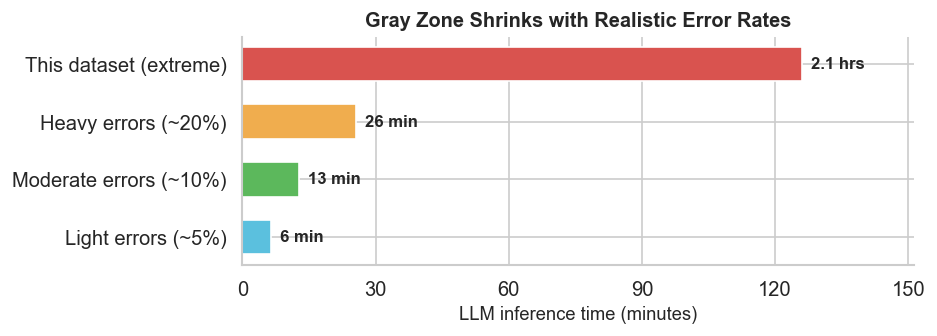


The LLM stage scales with ambiguity, not with dataset size.


In [12]:
# ── Computational feasibility analysis ────────────────────────────────
import json as _json
from pathlib import Path as _Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Load resolve metrics
_metrics_path = _Path("../output/resolved/resolve_metrics.json")
with open(_metrics_path) as _f:
    _rm = _json.load(_f)

candidate_pairs = _rm["candidate_pairs"]
auto_match_count = _rm["auto_match_count"]
gray_zone_count = _rm["gray_zone_count"]
auto_reject_count = _rm["auto_reject_count"]

# Observed throughput (H100, 4-bit quantized MedGemma 4B, batch_size=16)
THROUGHPUT = 20  # comparisons/sec
H100_COST_PER_HR = 2.79  # $/hr (RunPod on-demand)

gray_zone_secs = gray_zone_count / THROUGHPUT
gray_zone_hrs = gray_zone_secs / 3600
gray_zone_cost = gray_zone_hrs * H100_COST_PER_HR

gray_zone_pct = gray_zone_count / candidate_pairs * 100

# ── Stage breakdown table ────────────────────────────────────────────
print("Stage Breakdown (this dataset: 2,500 patients, 8–12 errors/record)")
print("═" * 72)
print(f"{'Stage':<30s} {'Pairs':>10s} {'Time':>12s} {'Cost':>8s}")
print("─" * 72)
print(f"{'Splink screening (CPU)':<30s} {candidate_pairs:>10,d} {'~seconds':>12s} {'—':>8s}")
print(f"{'  → auto-match':<30s} {auto_match_count:>10,d}")
print(f"{'  → auto-reject':<30s} {auto_reject_count:>10,d}")
print(f"{'  → gray zone → LLM':<30s} {gray_zone_count:>10,d}")
print(f"{'MedGemma classifier (H100)':<30s} {gray_zone_count:>10,d} {gray_zone_hrs:>11.1f}h {'$'+f'{gray_zone_cost:.0f}':>8s}")
print("─" * 72)
print(f"{'Total':<30s} {candidate_pairs:>10,d} {gray_zone_hrs:>11.1f}h {'$'+f'{gray_zone_cost:.0f}':>8s}")
print()
print(f"Throughput: ~{THROUGHPUT} comparisons/sec  │  "
      f"Gray zone: {gray_zone_pct:.1f}% of candidates  │  "
      f"GPU: H100 (4-bit quantized, <8 GB VRAM)")

# ── Real-world projection ────────────────────────────────────────────
print()
print()
print("Real-World Projection")
print("═" * 72)
print("This dataset deliberately uses extreme error rates (8–12 per record)")
print("to stress-test the system, pushing 98% of pairs into the gray zone.")
print("Real EHR data has far lower error rates.")
print()

scenarios = [
    ("This dataset (extreme)", gray_zone_pct),
    ("Heavy errors (~20%)", 20),
    ("Moderate errors (~10%)", 10),
    ("Light errors (~5%)", 5),
]

print(f"{'Scenario':<28s} {'Gray zone %':>12s} {'LLM pairs':>12s} {'Time':>10s}")
print("─" * 72)
for label, pct in scenarios:
    pairs = int(candidate_pairs * pct / 100)
    secs = pairs / THROUGHPUT
    if secs >= 3600:
        time_str = f"{secs/3600:.1f} hrs"
    else:
        time_str = f"{secs/60:.0f} min"
    print(f"{label:<28s} {pct:>11.0f}% {pairs:>12,d} {time_str:>10s}")

# ── Bar chart ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 3))

labels = [s[0] for s in scenarios]
pcts = [s[1] for s in scenarios]
pairs_list = [int(candidate_pairs * p / 100) for p in pcts]
times_min = [p / THROUGHPUT / 60 for p in pairs_list]

colors = ["#d9534f", "#f0ad4e", "#5cb85c", "#5bc0de"]
bars = ax.barh(labels[::-1], times_min[::-1], color=colors[::-1], height=0.6)

for bar, t in zip(bars, times_min[::-1]):
    if t >= 60:
        lbl = f"{t/60:.1f} hrs"
    else:
        lbl = f"{t:.0f} min"
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            lbl, va="center", fontsize=10, fontweight="bold")

ax.set_xlabel("LLM inference time (minutes)", fontsize=11)
ax.set_title("Gray Zone Shrinks with Realistic Error Rates", fontsize=12, fontweight="bold")
ax.set_xlim(0, max(times_min) * 1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

print()
print("The LLM stage scales with ambiguity, not with dataset size.")

**Why is 98% gray zone extreme?** Our test dataset injects 8–12 errors per record — missing dates of birth, mutated names, changed addresses — far exceeding real-world EHR error rates. This deliberately pushes nearly every candidate pair into the uncertain zone where the LLM must decide.

In production, most pairs would auto-match (identical demographics) or auto-reject (clearly different patients) via Splink on CPU alone. **Splink is the scalability workhorse** — it screens all 154K candidate pairs in seconds. The LLM only handles the uncertain tail.

The model runs on a single GPU with **4-bit quantization** (fits in <8 GB VRAM). No multi-GPU setup or cloud API is needed.

---

## Summary

ClinFuse demonstrates that adding MedGemma's clinical understanding to demographic linkage resolves the fundamental limitation of demographics-only matching:

- **Fragmentation rate cut from 14.4% to 3.9%** — a **73% reduction** in patients whose records remain scattered across facilities
- **Unresolved patients cut from 47.7% to 26.0%** — a **46% reduction** in patients without perfect cluster resolution
- **Missed match rate cut from 25.6% to 9.0%** — a **65% reduction** in true links that go undetected
- **73% fewer split patients** — from 421 fragmented patients to 115 with MedGemma
- **2,702 additional patient links** recovered by MedGemma from 151,309 ambiguous pairs
- **Single H100 GPU** — 151K gray zone pairs classified at ~20 pairs/sec; real-world error rates would reduce the LLM workload by 80–90%

The cluster-level story is more compelling than pair-level F1 suggests: a single recovered link can transitively unify an entire patient cluster, so the non-linear benefit of MedGemma is best measured at the patient level.

The approach is generalizable: any domain where entity resolution faces noisy demographics but has rich contextual data (clinical records, transaction histories, behavioral patterns) can benefit from adding a clinical-context LLM.